# Control arm

In [1]:
import numpy as np
import pandas as pd
import pyvista as pv
import deepxde as dde

from pinnDSE.geom import MeshGeom
from pinnDSE.viz import *
from pinnDSE.elasticity import *
from pinnDSE.bc import *

Using TensorFlow 2 backend.

Instructions for updating:
non-resource variables are not supported in the long term


2 read mesh: 0.0069811344146728516


3 coordinate transform: 2.832446336746216
2 read results: 3.911526918411255
1 total mesh and result loading: 4.061157703399658
1 total edge processing: 0.3002035617828369


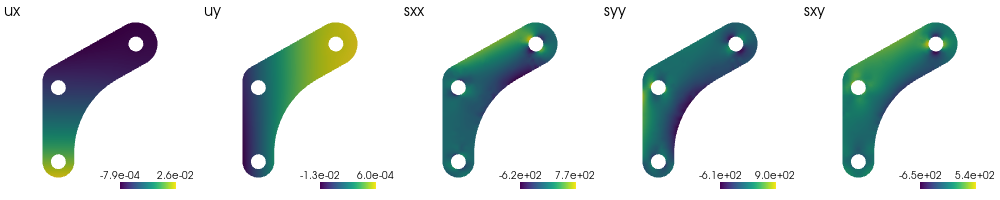

In [2]:
# load mesh and solver results
op2File = 'data/controlArm/v2.0/controlArm02.op2'
geom = MeshGeom(op2File, thickness=1.0)

# flip normals on inner edges so that they point inwards
geom.bndNormsDict[1] *= -1
geom.bndNormsDict[2] *= -1
geom.bndNormsDict[3] *= -1

plotScalarFields(geom.mesh, geom.resDf)

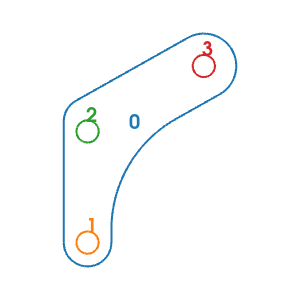

In [3]:
drawBoundaries(geom.bndDict)

Compiling model...
Building feed-forward neural network...
'build' took 0.046875 s

'compile' took 0.989387 s

Initializing variables...
Training model...

Step      Train loss                                                                                                                            Test loss                                                                                                                             Test metric
0         [1.15e+03, 6.27e+00, 1.34e+04, 3.23e+04, 4.32e+04, 1.34e-08, 9.23e-07, 7.25e+01, 7.35e+01, 5.01e+03, 1.49e+02, 4.55e+03, 1.90e+01]    [1.19e+03, 7.46e+00, 1.35e+04, 3.28e+04, 4.33e+04, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  

Best model at step 0:
  train loss: 1.00e+05
  test loss: 9.07e+04
  test metric: []

'train' took 0.297171 s

Compiling model...
'compile' took 0.808836 s

Initializing variables...
Training model...

Step      Train loss                                                

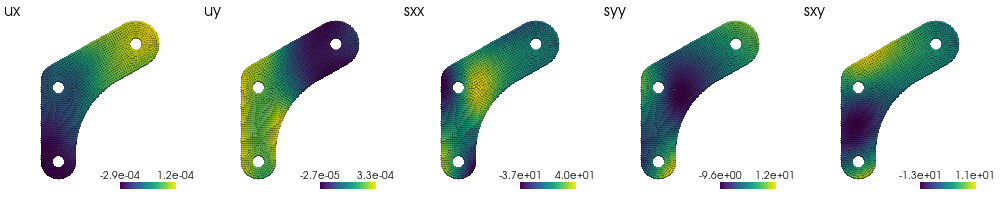

In [7]:
# supports
xBc = SupportBC(geom, bndId=3, U=0, component=0)
yBc = SupportBC(geom, bndId=3, U=0, component=1)

# traction free edges
xTr0 = TractionBC(geom, bndId=0, T=0, component=0)
yTr0 = TractionBC(geom, bndId=0, T=0, component=1)

# external loads
xTr1 = TractionBC(geom, bndId=1, T=34/geom.bndAreaDict[1], component=0)
yTr1 = TractionBC(geom, bndId=1, T=0, component=1)

xTr2 = TractionBC(geom, bndId=2, T=-34/geom.bndAreaDict[2], component=0)
yTr2 = TractionBC(geom, bndId=2, T=0, component=1)

# problem setup
bndNumSamplesDir = {0:800, 1:200, 2:200, 3:200}
paramDict = {'E':2.1e5, 'nu':0.3}
bcList = [xBc,yBc,xTr0,yTr0,xTr1,yTr1,xTr2,yTr2]
data = StrctPDE(geom, 
            elasticityEqs, 
            bcList, 
            num_domain=1000, 
            num_boundary_dir=bndNumSamplesDir, 
            num_test=500,
            paramDict=paramDict)

for bc in bcList:
    if isinstance(bc, TractionBC): 
        bc.train_n = data.train_n

# build model
net = dde.maps.FNN([2] + [64]*4  + [5], "tanh", "Glorot uniform")
outScales = np.array([1e-2, 1e-2, 1e2, 1e2, 1e2]) # [ux,uy,sxx,syy,sxy]
net.apply_output_transform(lambda x,y : y*outScales) 
model = dde.Model(data, net)

# get the unweighted loss values
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=0)
lw = losshistory.loss_train[0]**(-1)
lw1 = lw
lw[9] *= 100
lw[11] *= 100
lw[12] *= 10

# train
model.compile("adam", lr=0.001, loss_weights=lw)
losshistory, train_state = model.train(epochs=1000, display_every=100)

pred = model.predict(geom.mesh.points[:,:2])
predDf = pd.DataFrame(pred, columns=['ux', 'uy', 'sxx', 'syy', 'sxy'])
pc = pv.PolyData(geom.mesh.points)
plotScalarFields(pc, predDf)

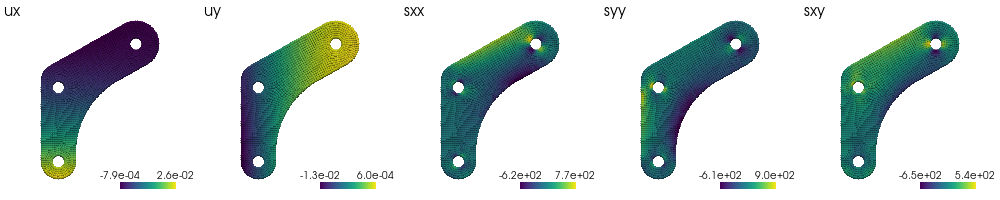

In [5]:
plotScalarFields(pc, geom.resDf)

In [8]:
bcNames = ['xBc','yBc','xTr0','yTr0','xTr1','yTr1','xTr2','yTr2']
# lines = alt.Chart(pd.DataFrame({'step':[1000,3000,4000]})).mark_rule(color='gray').encode(x='step:Q')
lossPlot(losshistory, bcNames, dropFirstStep=True)

alt.Chart(...)

Compiling model...
'compile' took 0.735997 s

Training model...

Step      Train loss                                                                                                                            Test loss                                                                                                                             Test metric
1000      [2.26e+01, 8.89e-01, 1.66e-01, 2.38e-02, 1.92e-02, 7.47e-01, 2.96e-04, 4.31e+00, 3.45e-01, 6.83e+01, 4.30e-02, 6.79e+01, 1.26e-01]    [1.56e+01, 1.36e+00, 1.60e-01, 1.97e-02, 1.98e-02, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
1100      [2.24e+01, 5.30e-01, 1.07e-01, 1.77e-02, 2.17e-02, 1.41e-02, 1.53e-05, 4.34e+00, 3.29e-01, 6.82e+01, 5.83e-02, 6.79e+01, 1.30e-01]    [1.55e+01, 6.57e-01, 7.74e-02, 1.52e-02, 2.45e-02, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
1200      [2.41e+01, 7.06e-01, 1.33e-01, 1.87e-02, 2.25e-02, 2.79e-03, 6.15e-05

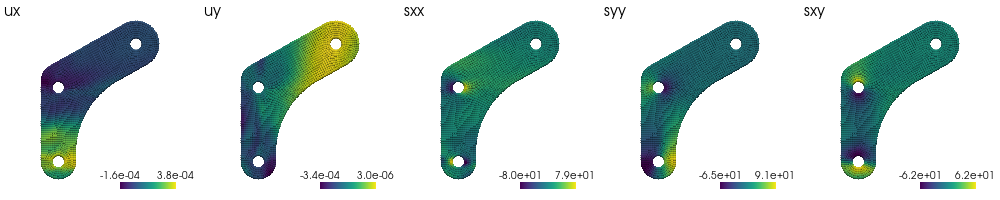

In [9]:
# switch back to the original weights
model.compile("adam", lr=0.001, loss_weights=lw1)
losshistory, train_state = model.train(epochs=10000, display_every=100)

pred = model.predict(geom.mesh.points[:,:2])
predDf = pd.DataFrame(pred, columns=['ux', 'uy', 'sxx', 'syy', 'sxy'])
pc = pv.PolyData(geom.mesh.points)
plotScalarFields(pc, predDf)

In [10]:
bcNames = ['xBc','yBc','xTr0','yTr0','xTr1','yTr1','xTr2','yTr2']
# lines = alt.Chart(pd.DataFrame({'step':[1000,3000,4000]})).mark_rule(color='gray').encode(x='step:Q')
lossPlot(losshistory, bcNames, dropFirstStep=True)

alt.Chart(...)

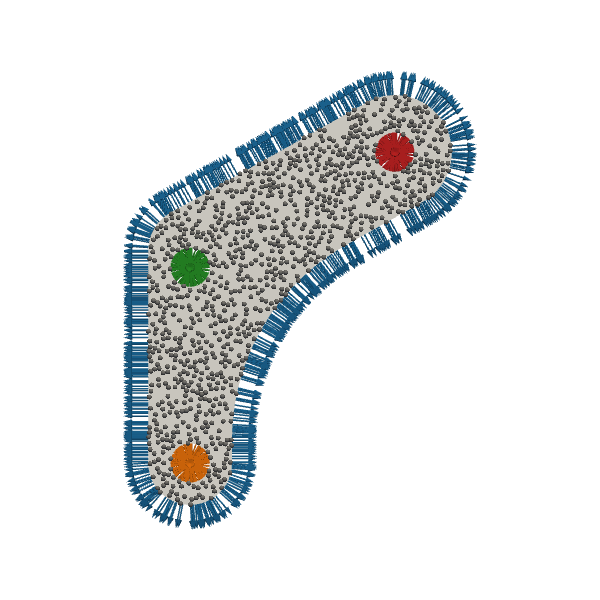

In [12]:
plotter = pv.Plotter(border=False)
plotter.set_background('white')
plotter.add_mesh(geom.mesh, show_edges=False)

# domain samples
pc = pv.PolyData(addZ(data.domainSamples))
plotter.add_mesh(pc, render_points_as_spheres=True, color='gray')

# boundary samples
for bndId, color in zip(geom.bndDict.keys(), CATEGORY10):
    samples = addZ(data.bndSampleDict[bndId])
    normals = addZ(data.bndNormalsDict[bndId])
    plotter.add_arrows(samples, normals, 0.1, color=color)
plotter.show(window_size=(600,600), cpos='xy');